<img src="logo-pirelli-dsa.png" align="left"/> 
<br>
## PF10 Defect Predictor
## Supervised Learning - Classification
<br>Pirelli Pneus Ltda.
<br>Area: Building / Finishing (Campinas Factory)
***
**Responsible:**
<br>Danillo Silva (SMO LatAm)
***

In [1]:
#Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

### Extract Data:
***

In [2]:
#Extract VMI Process Parameters:

df_vmi = pd.read_pickle('df_raw_results.pkl')

df_vmi.info(verbose=False)
df_vmi.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 8493 to 61255
Columns: 252 entries, ProductionDataId to UNB_ST_GR
dtypes: datetime64[ns](2), float64(49), int64(65), object(136)
memory usage: 8.8+ MB


,ProductionDataId,UserGroupName,UserName,RecipeName,ProductionOrderName,VST_VHMC_MES_MACHINE_NUMBER,VDT_VHMC_MES_DATE_TIME_STAMP,VST_VHMC_MES_GT_BARCODE,VRL_VHMC_MES_TIRE_COUNTER_TOTAL,VRL_VHMC_MES_TIRE_COUNTER_SHIFT,...,RRO,RRO_GR,COUPLE,COUPLE_GR,UNB_DY_LO,UNB_DY_LO_GR,UNB_DY_UP,UNB_DY_UP_GR,UNB_ST,UNB_ST_GR
53355,92789,PRODUÇÃO,OPERADOR,27214 245/70 R16 111T XL S-A/T+,NaN,VMI3,2019-02-09 18:30:34.966589,7176413511,326675,28,...,0.43,A,0.0,--,0.0,--,0.0,--,0.0,--
9425,13746,PRODUÇÃO,OPERADOR,27978 - 255/65 R18 111T SCSTAS,NaN,VMI2,2019-01-21 09:25:13.779774,7176356563,354127,21,...,0.78,A,0.0,--,0.0,--,0.0,--,0.0,--
11817,16339,PRODUÇÃO,OPERADOR,27978 - 255/65 R18 111T SCSTAS,NaN,VMI2,2019-01-24 10:00:48.403364,7176454174,356699,133,...,0.61,A,0.0,--,0.0,--,0.0,--,0.0,--
59309,105898,PRODUÇÃO,OPERADOR,27214 245/70 R16 111T XL S-A/T+,NaN,VMI3,2019-02-12 19:24:49.021208,7176416145,329309,147,...,0.33,A,0.0,--,0.0,--,0.0,--,0.0,--
60995,109362,PRODUÇÃO,OPERADOR,27214 245/70 R16 111T XL S-A/T+,NaN,VMI3,2019-02-13 16:55:55.216530,7176416853,330016,56,...,0.41,A,0.0,--,0.0,--,0.0,--,0.0,--


### Subset DataFrame:
***

In [3]:
#Show Table w/ IPCODES vs. Conicity Grades (sorted by 'E' Grade):

df_vmi.groupby(['IP_CODE','CONICITY_GR']).agg({'GR_MISURA':'count'}).pivot_table(
    index='IP_CODE', columns='CONICITY_GR', values='GR_MISURA').sort_values('E',ascending=False).replace(np.nan,0)

CONICITY_GR,A,D,E
IP_CODE,,,
27978,2488.0,0.0,511.0
27214,1492.0,19.0,1.0
16175,1.0,0.0,0.0
17180,37.0,1.0,0.0


In [4]:
#Select and Subset Data Frame for 1 IP Code:

ip_code = df_vmi.groupby(['IP_CODE','CONICITY_GR']).agg({'GR_MISURA':'count'}).pivot_table(
    index='IP_CODE', columns='CONICITY_GR', values='GR_MISURA').sort_values('E',ascending=False).index[0]

df_vmi = df_vmi[df_vmi['IP_CODE'] == ip_code]

df_vmi.index = df_vmi['Barcode']

### Feature Selection:
***

In [5]:
#Feature Selection Using Campinas Quality Input from Product:

features = ['VRL_VHMC_MES_1BAP_BODY_AVERAGE_WIDTH',
            'VRL_VHMC_MES_1BAP_SPLICE_AVG_OFF_CENTER',
            'VRL_VHMC_MES_1BAP_SPLICE_AVG_OPEN_OVER_M',
            'VRL_VHMC_MES_2BAP_BODY_AVERAGE_WIDTH',
            'VRL_VHMC_MES_2BAP_SPLICE_AVG_OFF_CENTER',
            'VRL_VHMC_MES_2BAP_SPLICE_AVG_OPEN_OVER_M',
            'VRL_VHMC_MES_TD_WIDTH_MEASURED',
            'VRL_VHMC_MES_TD_LENGTH_MEASURED',
            'CONICITY_GR',
            'CONICITY']


df_vmi = df_vmi[features]

df_vmi.rename(columns={'VRL_VHMC_MES_1BAP_BODY_AVERAGE_WIDTH':'LARGURA_CN1',
                       'VRL_VHMC_MES_1BAP_SPLICE_AVG_OFF_CENTER':'OFFSET_CN1',
                       'VRL_VHMC_MES_1BAP_SPLICE_AVG_OPEN_OVER_M':'SORMONTO_CN1',
                       'VRL_VHMC_MES_2BAP_BODY_AVERAGE_WIDTH':'LARGURA_CN2',
                       'VRL_VHMC_MES_2BAP_SPLICE_AVG_OFF_CENTER':'OFFSET_CN2',
                       'VRL_VHMC_MES_2BAP_SPLICE_AVG_OPEN_OVER_M':'SORMONTO_CN2',
                       'VRL_VHMC_MES_TD_WIDTH_MEASURED':'LARG_RODAGEM',
                       'VRL_VHMC_MES_TD_LENGTH_MEASURED':'COMP_RODAGEM'}, inplace=True)

df_vmi.sample(5)

,LARGURA_CN1,OFFSET_CN1,SORMONTO_CN1,LARGURA_CN2,OFFSET_CN2,SORMONTO_CN2,LARG_RODAGEM,COMP_RODAGEM,CONICITY_GR,CONICITY
Barcode,,,,,,,,,,
7176398641,"222,2468","1,078788","0,2052361","210,1212","0,8700907","-0,3814787","254,07","2338,099",E,-16.3
7176388506,"219,9636","0,8398598","-0,277447","210,2075","0,3729149","-0,1227831","252,93","2339,469",A,-8.7
7176388456,"219,0058","0,9242849","-0,6502445","210,1127","0,2686121","-0,2731663","253,83","2340,772",E,-17.8
7176356656,"218,5519","-0,4389725","0,1644216","209,1544","-0,8858969","0,1163859","251,09","2337,071",A,-5.5
7176457537,"217,7746","-0,3079681","-0,3875403","206,7631","-1,073217","0,03326828","255,42","2334,606",A,-7.6


### Exploratory Data Analysis:
***

In [6]:
#Convert all Values to Float:

for i in range(len(list(df_vmi.columns[0:-2]))):
    df_vmi[df_vmi.columns[i]] = df_vmi[df_vmi.columns[i]].replace({',':'.'},regex=True).apply(pd.to_numeric,1)

In [7]:
#Main Figures from DataFrame:

df_vmi.describe()

,LARGURA_CN1,OFFSET_CN1,SORMONTO_CN1,LARGURA_CN2,OFFSET_CN2,SORMONTO_CN2,LARG_RODAGEM,COMP_RODAGEM,CONICITY
count,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000,2999.000000
mean,220.019140,-0.036119,-0.285166,207.938013,-0.467797,-0.056374,253.885275,2337.810884,-8.920674
std,1.534317,0.743422,0.628849,4.386751,1.234315,0.432616,1.246645,2.496376,4.000358
min,207.744400,-1.907806,-6.671711,0.000000,-3.370212,-6.024405,248.460000,2323.058000,-20.900000
25%,219.033550,-0.607977,-0.548212,206.774250,-1.436807,-0.219779,253.160000,2336.435000,-11.400000
50%,219.839200,-0.248779,-0.175230,208.458500,-0.944306,-0.004869,253.780000,2337.768000,-8.500000
75%,221.238450,0.556021,0.004376,209.643400,0.761859,0.141333,254.575000,2339.131000,-6.300000
max,229.928900,2.496403,10.563160,220.056300,3.048680,4.022602,265.790000,2388.719000,12.000000


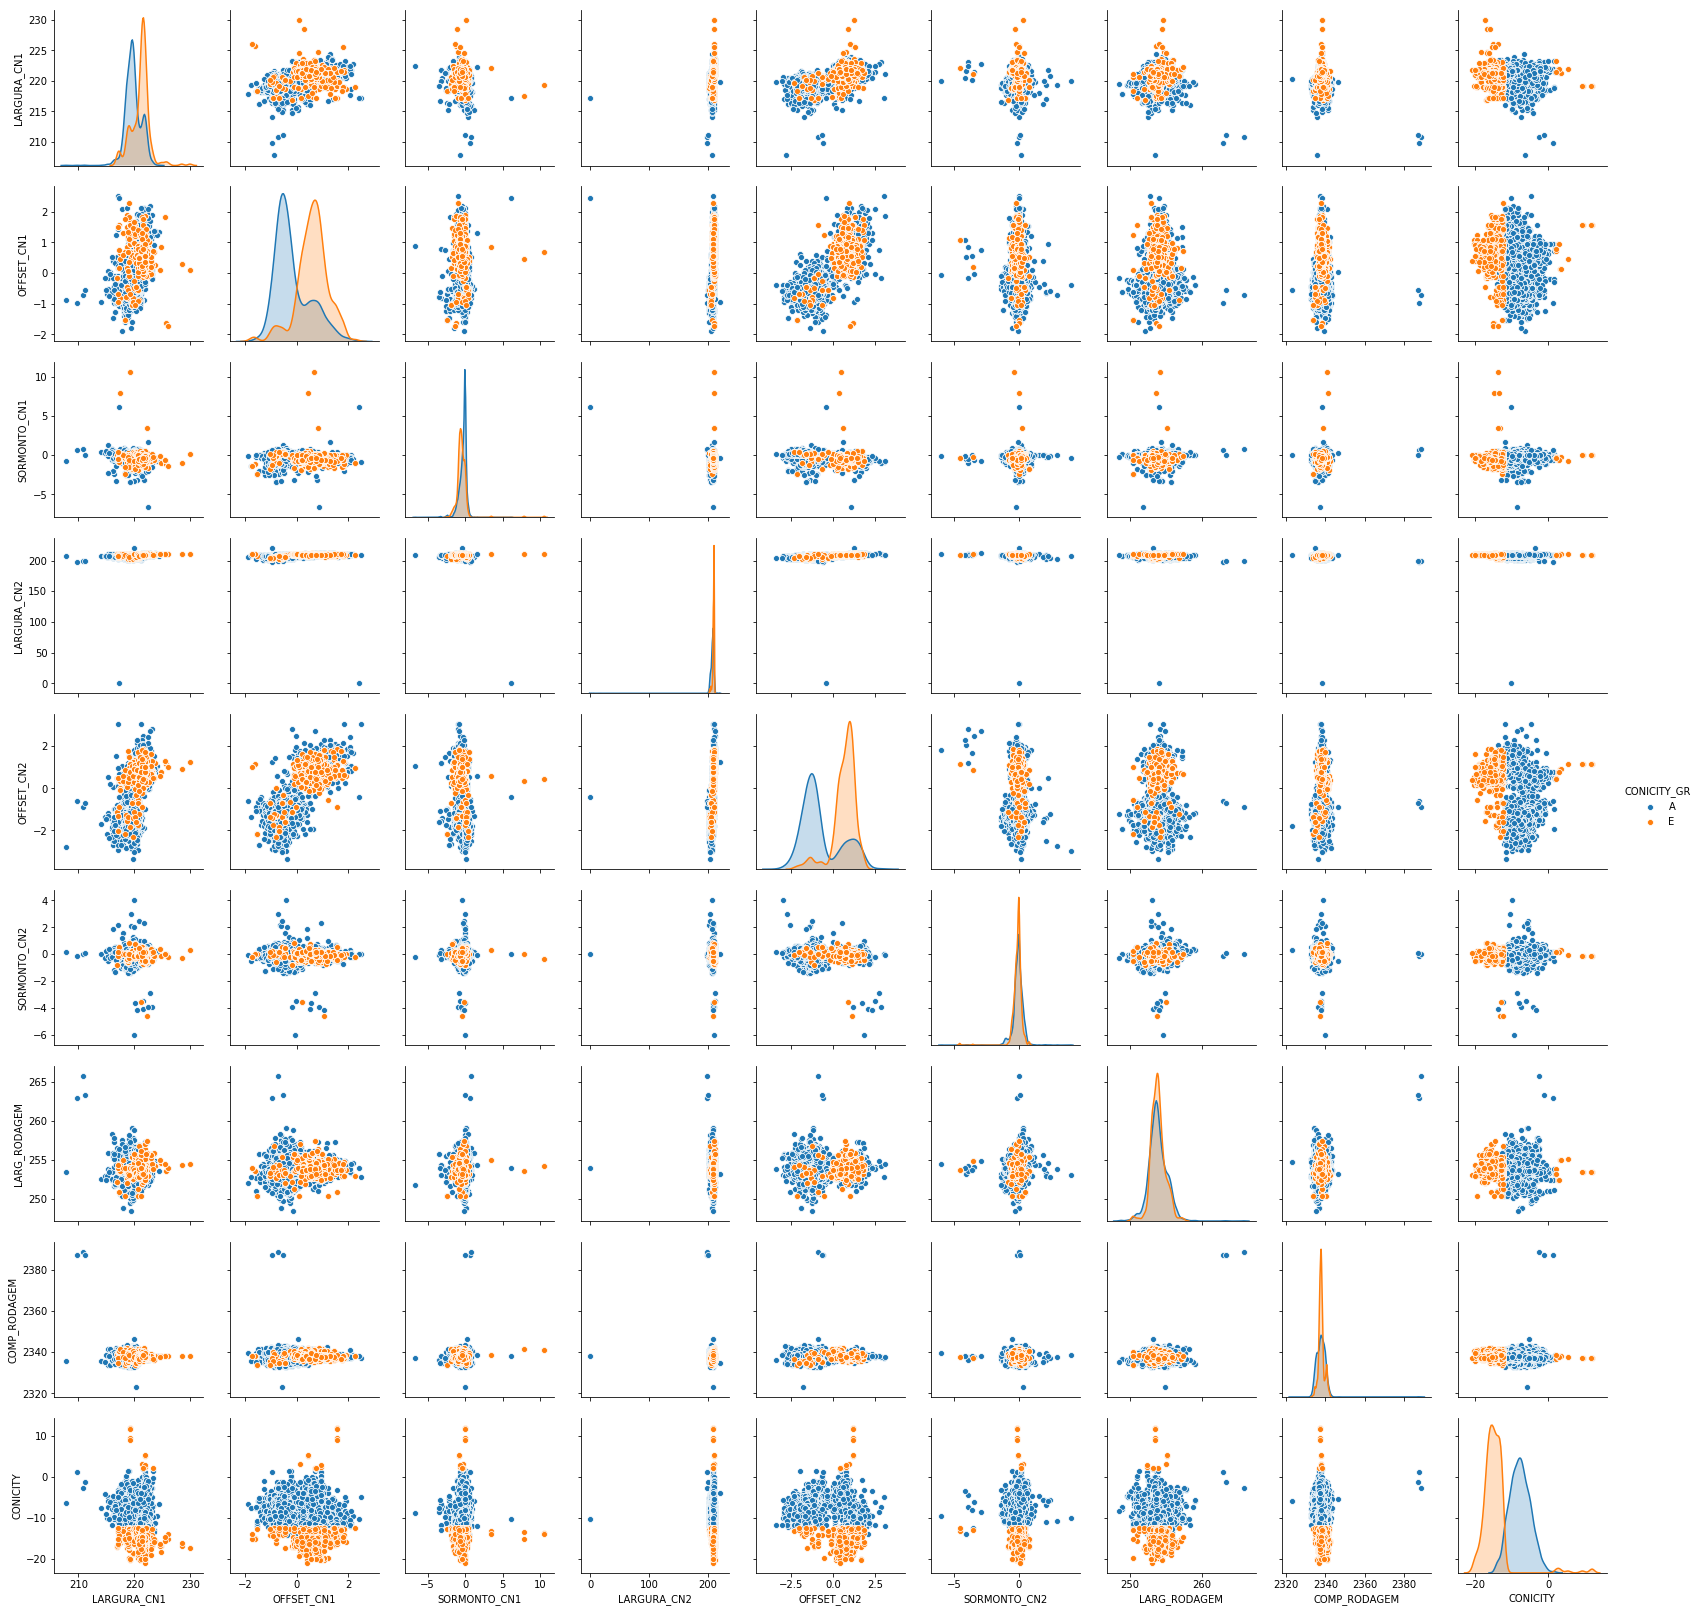

In [8]:
#Plot all Possible Correlations:

sns.pairplot(df_vmi, hue='CONICITY_GR')

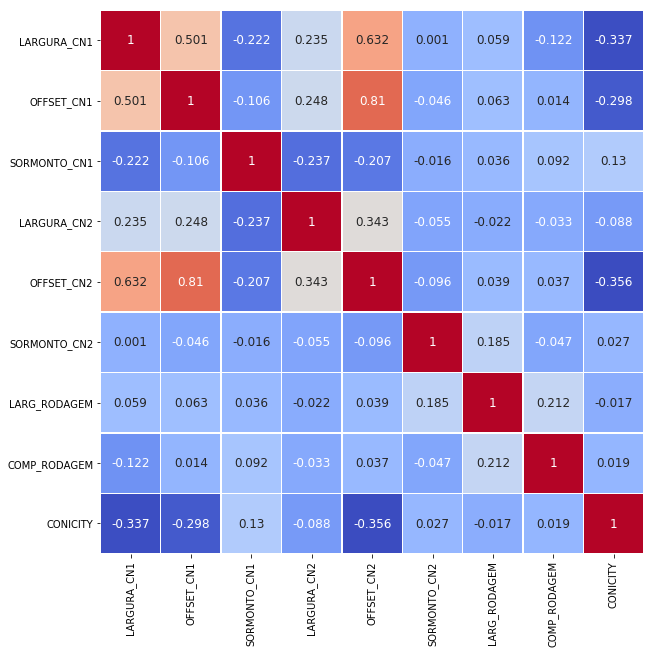

In [9]:
#Main Correlations:

_= plt.figure(figsize=(10,10))

sns.heatmap(round(df_vmi.corr(),3),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
            cmap='coolwarm', annot_kws={'size': 12}, fmt='g')

### Predictive Modeling - Features Split (Train/Test):
***

In [10]:
#Define X and y:

df_vmi['TARGET'] = pd.get_dummies(df_vmi['CONICITY_GR']).iloc[:,0]

X = df_vmi.iloc[:,0:-3]
y = df_vmi.iloc[:,-1]

In [11]:
#Split Train and Test Samples:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### RandomForest Approach:
***

In [12]:
#List of all available parameters from RandomForest Model:

forest_clf = RandomForestClassifier()

forest_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [13]:
#Main Parameters Selection:

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini','entropy']

In [14]:
#Random Grid Creation with Parameters:

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':criterion}

In [15]:
#Set GridSearch Using RandomizedSearchCV:

rf_random = RandomizedSearchCV(estimator=forest_clf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

In [16]:
#Process RandomForest Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

rf_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.2min finished


Executed in: 0 days 00:10:11.949502


In [17]:
#Inspect Best Parameters:

rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 70,
 'criterion': 'gini',
 'bootstrap': False}

In [18]:
#Use Best Estimators for Model:

print(rf_random.best_estimator_)

rf_model = rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=70, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [24]:
#Create Predictions based upon RandomForest Model:

pred = rf_model.predict(X_test)
pred_proba_pos = rf_model.predict_proba(X_test)[:,1]

Random Forest Model: 84.16%


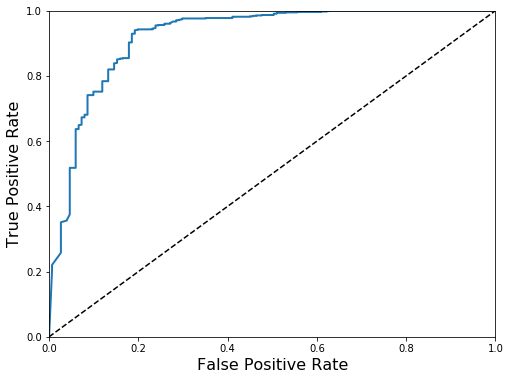

In [25]:
#Plot and Print Accuracy Results (ROC):

fpr, tpr, thresholds_forest = roc_curve(y_test.values,pred_proba_pos)

print('Random Forest Model: {}%'.format(round(roc_auc_score(y_test, pred)*100,2)))

_= plt.figure(figsize=(8, 6))

_= plt.plot(fpr, tpr, linewidth=2)
_= plt.plot([0, 1], [0, 1], 'k--')
_= plt.axis([0, 1, 0, 1])
_= plt.xlabel('False Positive Rate', fontsize=16)
_= plt.ylabel('True Positive Rate', fontsize=16)



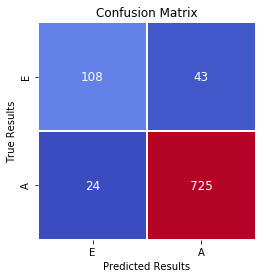

In [26]:
#Plot Confusion Matrix:

sns.heatmap(confusion_matrix(y_test, pred),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
            cmap='coolwarm', annot_kws={'size': 12}, fmt='g')

_= plt.xticks([0.5,1.5],['E','A'])
_= plt.yticks([0.5,1.5],['E','A'])

_= plt.ylabel('True Results')
_= plt.xlabel('Predicted Results')

_= plt.title('Confusion Matrix')

### GradientBoosting Classifier:
***

In [27]:
#List of all available parameters from GradientBoosting Model:

GBC_classifier = GradientBoostingClassifier()

GBC_classifier.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [29]:
#Main Parameters Selection:

n_estimators = [500, 1000, 1500, 2000, 2500]
learning_rate = [0.01, 0.03, 0.05, 0.07, 0.09, 1]
min_samples_split = [2,4,6,8,10]
min_samples_leaf = [3,5,7,9,11]

In [30]:
#Random Grid Creation with Parameters:

random_grid = {'n_estimators':n_estimators, 
              'learning_rate':learning_rate,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

In [31]:
#Set GridSearch Using RandomizedSearchCV:

GBC_random = RandomizedSearchCV(estimator=GBC_classifier,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

In [32]:
#Process RandomForest Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

GBC_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished


Executed in: 0 days 00:04:53.999408


In [33]:
#Inspect Best Parameters:

GBC_random.best_params_

{'n_estimators': 2500,
 'min_samples_split': 10,
 'min_samples_leaf': 11,
 'learning_rate': 0.07}

In [34]:
#Use Best Estimators for Model:

print(GBC_random.best_estimator_)

GBC_model = GBC_random.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.07, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=11, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=2500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [35]:
#Create Predictions based upon GradientBoosting Model:

pred = GBC_model.predict(X_test)
pred_proba_pos = GBC_model.predict_proba(X_test)[:,1]

Random Forest Model: 83.09%


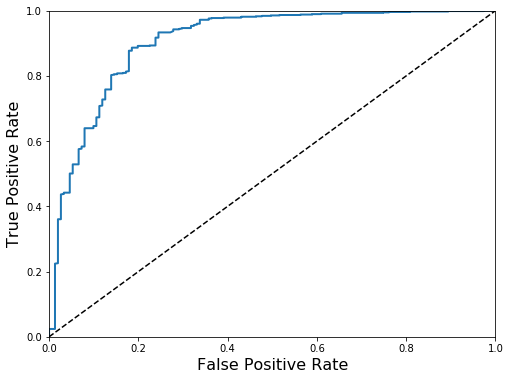

In [36]:
#Plot and Print Accuracy Results (ROC):

fpr, tpr, thresholds_forest = roc_curve(y_test.values,pred_proba_pos)

print('Random Forest Model: {}%'.format(round(roc_auc_score(y_test, pred)*100,2)))

_= plt.figure(figsize=(8, 6))

_= plt.plot(fpr, tpr, linewidth=2)
_= plt.plot([0, 1], [0, 1], 'k--')
_= plt.axis([0, 1, 0, 1])
_= plt.xlabel('False Positive Rate', fontsize=16)
_= plt.ylabel('True Positive Rate', fontsize=16)

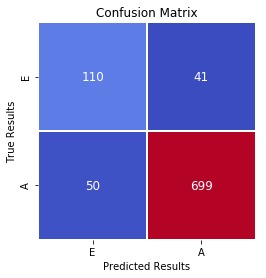

In [37]:
#Plot Confusion Matrix:

sns.heatmap(confusion_matrix(y_test, pred),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
            cmap='coolwarm', annot_kws={'size': 12}, fmt='g')

_= plt.xticks([0.5,1.5],['E','A'])
_= plt.yticks([0.5,1.5],['E','A'])

_= plt.ylabel('True Results')
_= plt.xlabel('Predicted Results')

_= plt.title('Confusion Matrix')

### xgboost Classifier:
***

In [38]:
#List of all available parameters from RandomForest Model:

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.02,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 600,
 'n_jobs': 1,
 'nthread': 1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1,
 'verbosity': 1}

In [39]:
#Main Parameters Selection:

min_child_weight = [1, 5, 10]
gamma = [0.5, 1, 1.5, 2, 5]
subsample = [0.6, 0.8, 1.0]
colsample_bytree = [0.6, 0.8, 1.0]
max_depth = [3, 4, 5]

In [40]:
# A parameter grid for XGBoost

random_grid = {'min_child_weight': min_child_weight,
               'gamma': gamma ,
               'subsample': subsample ,
               'colsample_bytree': colsample_bytree,
               'max_depth': max_depth
               }

In [41]:
#Set GridSearch Using RandomizedSearchCV:

xgb_random = RandomizedSearchCV(estimator=xgb,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

In [42]:
#Process RandomForest Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

xgb_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Executed in: 0 days 00:02:02.813994


In [43]:
#Inspect Best Parameters:

xgb_random.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

In [44]:
#Use Best Estimators for Model:

print(xgb_random.best_estimator_)

xgb_model = xgb_random.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
       learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
       nthread=1, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6, verbosity=1)


In [45]:
#Create Predictions based upon GradientBoosting Model:

pred = xgb_model.predict(X_test)
pred_proba_pos = xgb_model.predict_proba(X_test)[:,1]

Random Forest Model: 82.23%


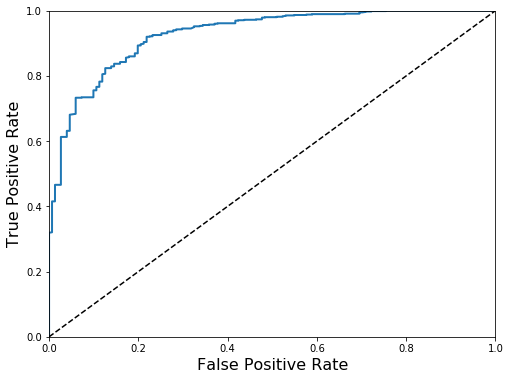

In [46]:
#Plot and Print Accuracy Results (ROC):

fpr, tpr, thresholds_forest = roc_curve(y_test.values,pred_proba_pos)

print('Random Forest Model: {}%'.format(round(roc_auc_score(y_test, pred)*100,2)))

_= plt.figure(figsize=(8, 6))

_= plt.plot(fpr, tpr, linewidth=2)
_= plt.plot([0, 1], [0, 1], 'k--')
_= plt.axis([0, 1, 0, 1])
_= plt.xlabel('False Positive Rate', fontsize=16)
_= plt.ylabel('True Positive Rate', fontsize=16)

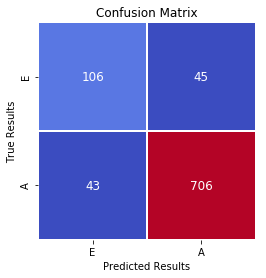

In [47]:
#Plot Confusion Matrix:

sns.heatmap(confusion_matrix(y_test, pred),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
            cmap='coolwarm', annot_kws={'size': 12}, fmt='g')

_= plt.xticks([0.5,1.5],['E','A'])
_= plt.yticks([0.5,1.5],['E','A'])

_= plt.ylabel('True Results')
_= plt.xlabel('Predicted Results')

_= plt.title('Confusion Matrix')